## Convert xml file to csv

In [122]:
from xml.dom.minidom import parse
import xml.dom.minidom
import pandas as pd
from pandas import DataFrame
DOMTree = xml.dom.minidom.parse("aim-24-260.pdf.tei.xml")
collection = DOMTree.documentElement

In [123]:
divs = collection.getElementsByTagName('div')

In [126]:
output=[]
for div in divs:
    sentences=div.getElementsByTagName('s')
    for sentence in sentences:
        try:
            output.append(sentence.childNodes[0].data)
        except:
            pass

In [127]:
DataFrame(output,columns=['sentence']).to_csv('aim-24-260.pdf.tei.csv',index=None)

### Import all the stuff

In [128]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


### Read Data


In [129]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("aim-24-260.pdf.tei.csv")
candidate_sentences.shape

(247, 1)

In [157]:
candidate_sentences['sentence'].sample(5)

102    As of April 8, 2020, 638 public health centers and medical institutions, including drive-thru and walkthru stations, were conducting screening.
242                          AO, AAS provided experts' opinion, helped in data interpretation and commented on intellectual development of manuscript.
203                                                                                          Adequate resource allocation is necessary but not enough.
190                  Besides, the 1666 call center with 120 hotlines has been allocated by the Health Insurance Organization of Iran for this purpose.
71                                                                                                   The first positive case of COVID-19 was confirmed
Name: sentence, dtype: object

In [131]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


### Entity Pairs Extraction

In [132]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [133]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [134]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 247/247 [00:02<00:00, 117.16it/s]


In [136]:
entity_pairs[0:11]

[['2019  world', 'last health decades'],
 ['official  number', '2.6 million'],
 ['Most  countries', 'disease'],
 ['Nevertheless  countries', 'adapted  policies'],
 ['first  we', 'informed policy lessons'],
 ['This', 'qualitative document Iran'],
 ['deductive  data', 'Building Blocks Framework'],
 ['Finally  we', 'selected  countries'],
 ['which', 'outcomes'],
 ['main  strategies', 'effective combat COVID-19'],
 ['vaccine', 'coronavirus']]

### Relation / Predicate Extraction

In [137]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [138]:
get_relation("John completed the task")


'completed'

In [139]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 247/247 [00:01<00:00, 130.18it/s]


In [140]:
pd.Series(relations).value_counts()[:50]

is                   7
confirmed            7
used                 6
announced            6
Figure               6
increased            5
contributed in       4
passed               4
have                 4
were                 4
developed            3
allocated            3
approved by          3
launched             3
collected            3
was                  3
are                  2
began                2
led to               2
AT conceived         2
revealed             2
provided             2
conducting           2
Contents of          2
introduced           2
called               2
is essential         2
contains             2
transferred to       2
report               2
applied              2
like                 2
formed under         2
had                  2
read                 2
declining in many    1
Japan                1
converted into       1
began from           1
remind               1
compared with        1
track                1
adopted different    1
obligated  

### Build a Knowledge Graph


In [141]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,2019 world,last health decades,facing
1,official number,2.6 million,passed
2,Most countries,disease,developed
3,Nevertheless countries,adapted policies,experienced different
4,first we,informed policy lessons,report


In [142]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

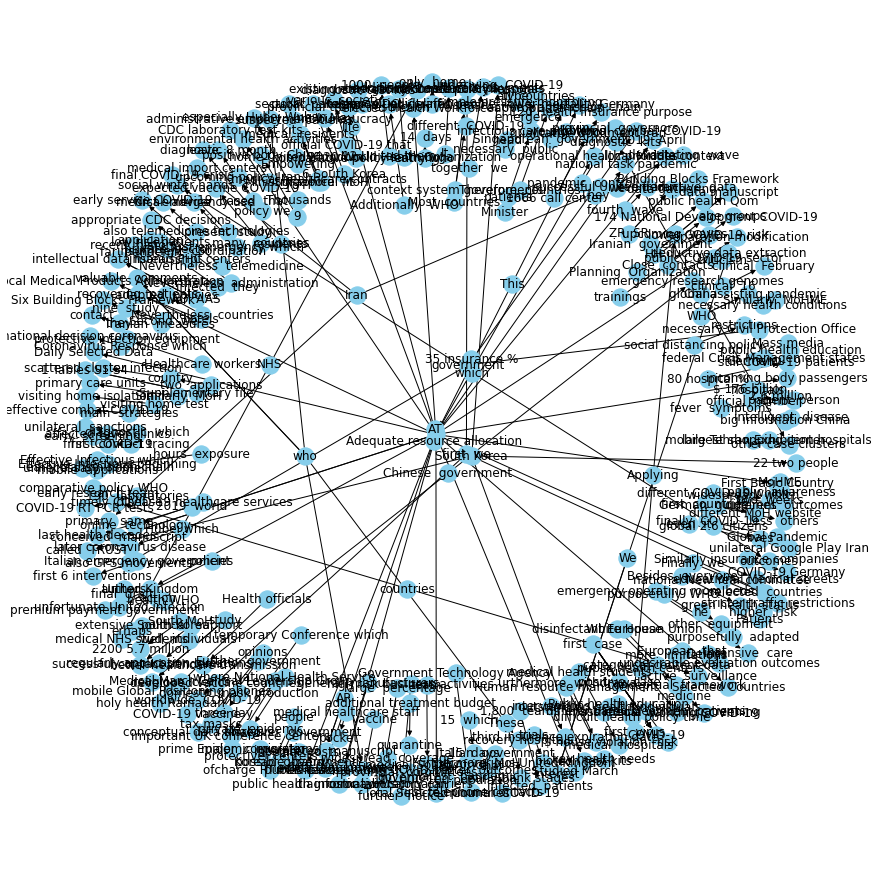

In [143]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

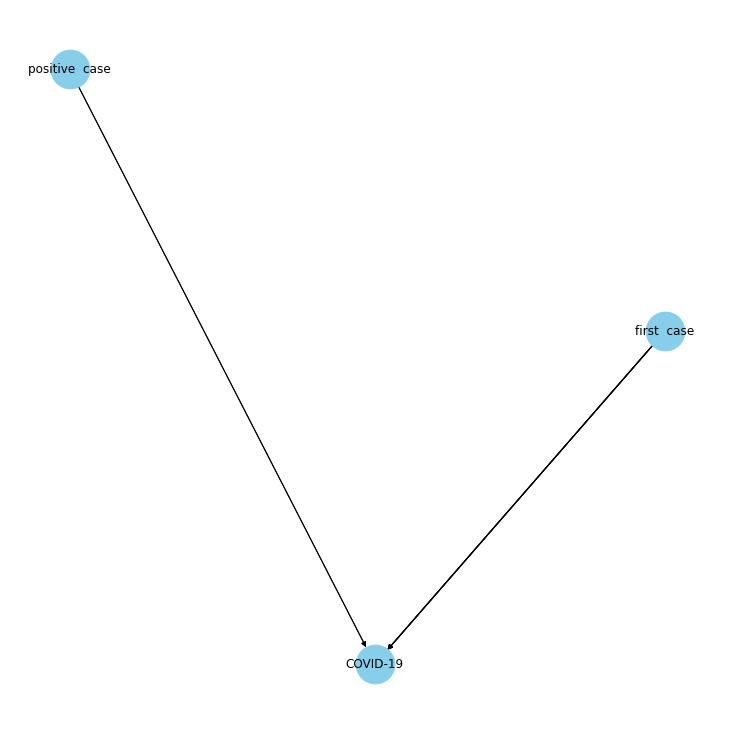

In [158]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="confirmed"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

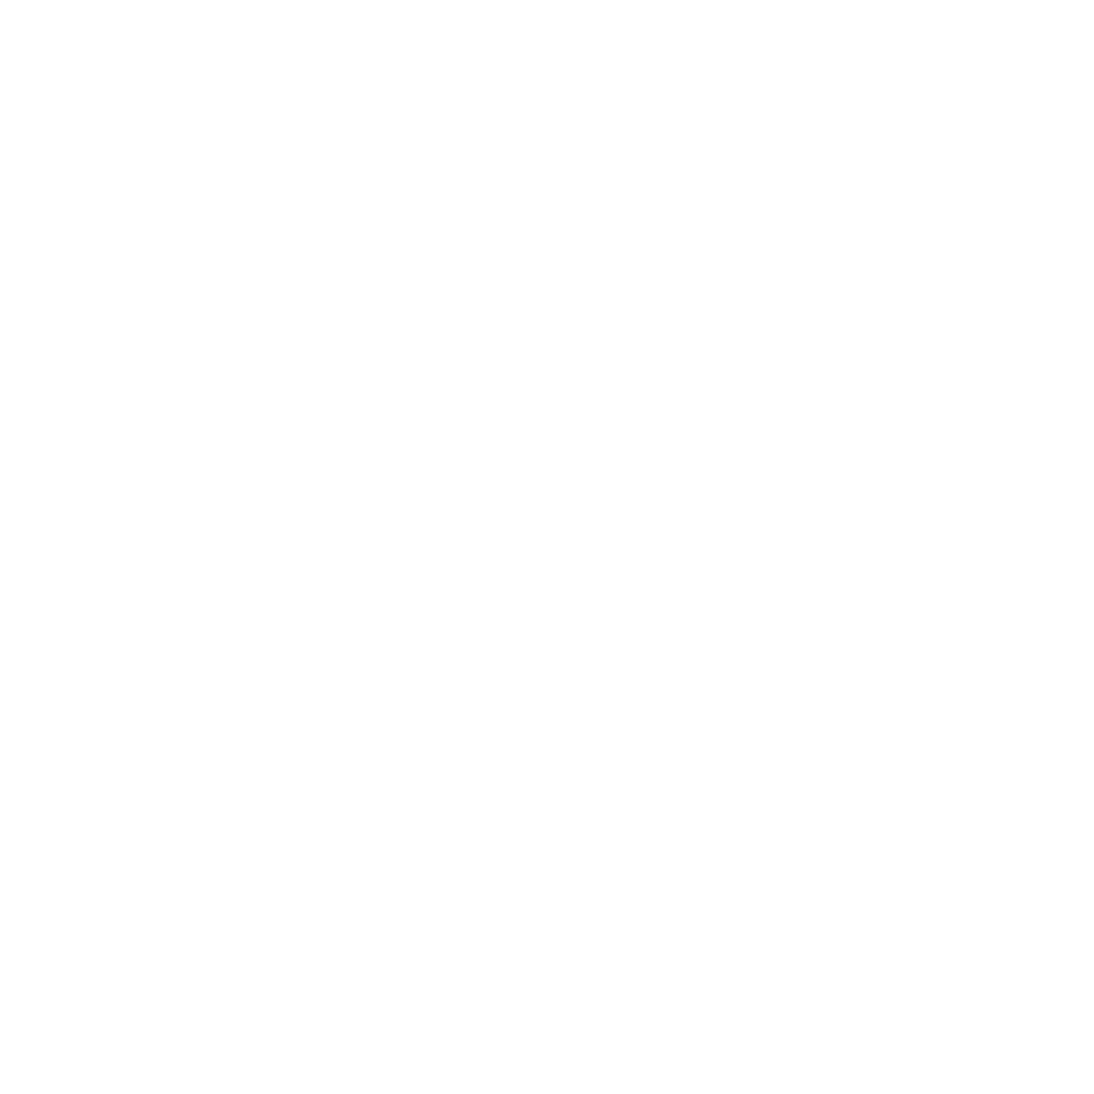

In [116]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

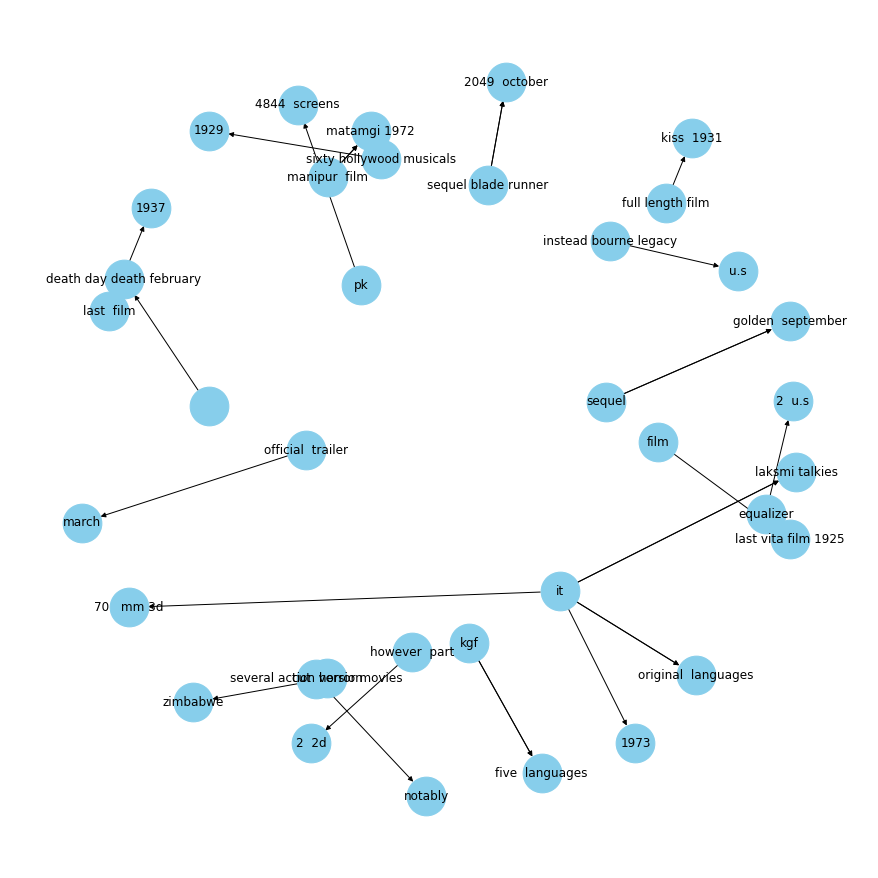

In [41]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

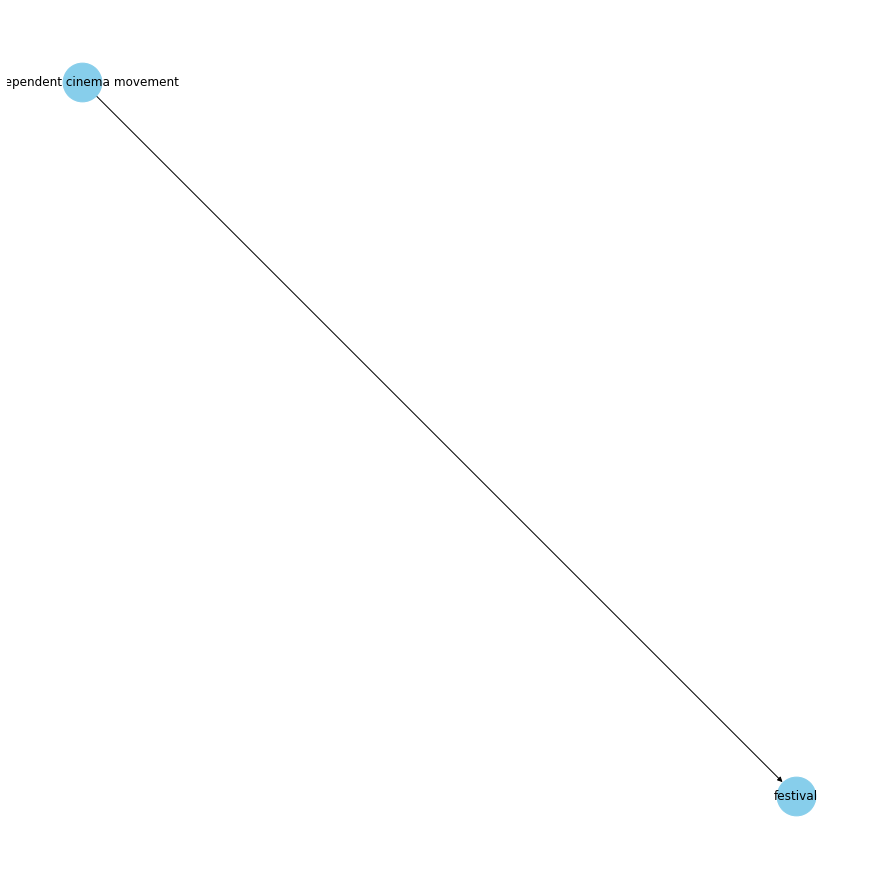

In [42]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="launched"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()